In [1]:
from pydub import AudioSegment
import numpy as np 
import matplotlib.pyplot as plt

In [2]:
audio = AudioSegment.from_file("Test.wav")
audio = audio.set_channels(1).set_frame_rate(16000)

In [3]:
samples = np.array(audio.get_array_of_samples())
duration = len(samples)/16000

In [4]:
times = np.linspace(0,duration,num=len(samples))

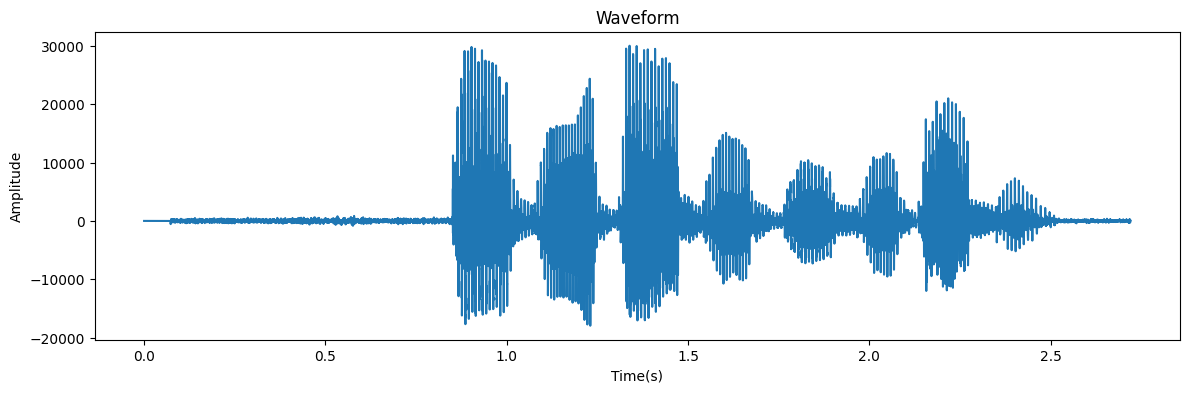

In [5]:
plt.figure(figsize=(14,4))
plt.plot(times,samples)
plt.title("Waveform")
plt.xlabel("Time(s)")
plt.ylabel("Amplitude")
plt.show()

In [6]:
Frame_size_ms = 30
Frame_step_ms = 15

In [7]:
frame_size = int(16000 * Frame_size_ms / 1000)  # samples per frame
frame_step = int(16000 * Frame_step_ms / 1000)

In [8]:
energies = []
time_energies = []

for start in range(0 , len(samples)-frame_size , frame_step):
    frame = samples[start:start+frame_size]
    energy = np.sum(frame.astype(float)**2)
    energies.append(energy)
    time_energies.append(start/16000.0)

In [9]:
energies = np.array(energies)
energies_db = 10 * np.log10(energies + 1e-6)

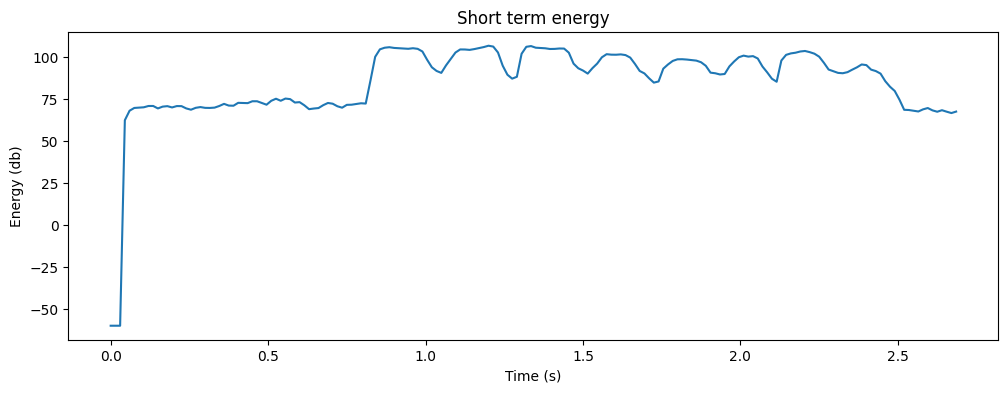

In [10]:
plt.figure(figsize=(12,4))
plt.plot(time_energies,energies_db)
plt.title("Short term energy")
plt.xlabel("Time (s)")
plt.ylabel("Energy (db)")
plt.show()

In [11]:
threshold = np.mean(energies_db) + 0.5*np.std(energies_db)
print(f"Energy Threshold: {threshold:.2f} dB")
vad_labels = (energies_db > threshold).astype(int)

Energy Threshold: 96.98 dB


In [12]:
def get_speech_segments(labels, times, frame_step_sec):
    segments = []
    start = None

    for i, label in enumerate(labels):
        if label == 1 and start is None:
            start = times[i]
        elif label == 0 and start is not None:
            end = times[i]
            if end - start > 0.02:  # Only keep speech longer than 20ms
                segments.append((start, end))
            start = None
    # Handle case where audio ends in speech
    if start is not None:
        segments.append((start, times[-1]))
    return segments

segments = get_speech_segments(vad_labels, time_energies, Frame_step_ms / 1000)

print("\nDetected Speech Segments:")
for start, end in segments:
    print(f"  - {start:.2f}s to {end:.2f}s")



Detected Speech Segments:
  - 0.84s to 1.02s
  - 1.08s to 1.25s
  - 1.30s to 1.47s
  - 1.56s to 1.67s
  - 1.78s to 1.89s
  - 1.98s to 2.07s
  - 2.13s to 2.27s


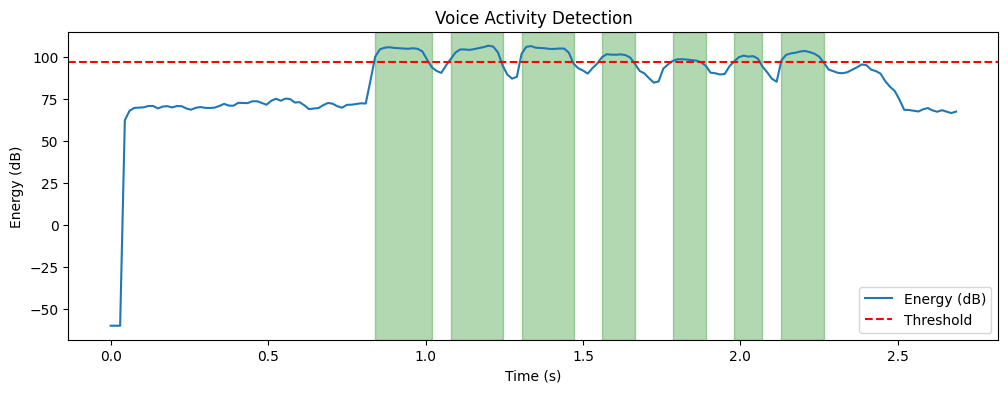

In [13]:
plt.figure(figsize=(12, 4))
plt.plot(time_energies, energies_db, label="Energy (dB)")
plt.axhline(threshold, color='red', linestyle='--', label='Threshold')

# Shade detected speech areas
for start, end in segments:
    plt.axvspan(start, end, color='green', alpha=0.3)

plt.title("Voice Activity Detection")
plt.xlabel("Time (s)")
plt.ylabel("Energy (dB)")
plt.legend()
plt.show()
